In [1]:
# could also include topography from National Land Coverage Database:
# https://pubs.usgs.gov/fs/2012/3020/

## VERY NICE VIDEO ON FORECASTING AND BUILDING SAS NN MODEL:
# https://blogs.sas.com/content/subconsciousmusings/2018/07/05/deep-learning-forecasts-solar-power/

# Another source for wind speed and power energy prediction
# https://github.com/ShashwatArghode/Wind-Energy-Prediction-using-LSTM/blob/master/CSE%20523%20Project%20Report.pdf

In [2]:
# import libraries and magic
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import spatial
import re
import geopandas
import requests
import glob
from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 14})

year = 2017

In [4]:
#### FROM PART 1 ####
# Load injested and cleaned wind energy generation data
# wind farm station metadata
wind_farm_stns_df = pd.read_csv('compiled_wind_farm_station_metadata_' + str(year) + '.csv')
wind_farm_stns_df['in_dataset'] = wind_farm_stns_df['in_dataset'].astype(bool)
wind_farm_stns_df = wind_farm_stns_df.loc[(
    (wind_farm_stns_df['station_type']=='Wind') &
    wind_farm_stns_df['in_dataset']),:]
wind_farm_stns_df.drop(columns=[
    'Unnamed: 0',
    'station_alt_name',
    'station_type',
    'in_dataset'],
    inplace=True)
wind_farm_stns_df.set_index('station_name', inplace=True)

# wind power data
wind_power_df = pd.read_csv('compiled_wind_power_data_' + str(year) + '.csv')
wind_power_df.drop(columns=['Unnamed: 0'],inplace=True)
wind_power_df.loc[:,'date'] = pd.to_datetime(wind_power_df['date'], format='%Y-%m-%d %H:%M:%S')
wind_power_df.loc[:,'datetime'] = pd.to_datetime(wind_power_df['datetime'], format='%Y-%m-%d %H:%M:%S')
wind_power_df.set_index('station_name', inplace=True)

# Join em up
wind_power_df = wind_power_df.join(wind_farm_stns_df).reset_index()
wind_farm_stns_df.reset_index(inplace=True)
display(wind_power_df.head(5))

,station_name,hour,date,datetime,power_output,pred_power_output,max_power_output,pmax_power_output,pred_pmax_power_output,latitude,longitude
0,ADELAIDE,0,2017-01-01,2017-01-01 00:00:00,10.0,45.0,60.0,0.166667,0.750000,43.100099,-81.634304
1,ADELAIDE,1,2017-01-01,2017-01-01 01:00:00,0.0,37.0,60.0,0.000000,0.616667,43.100099,-81.634304
2,ADELAIDE,2,2017-01-01,2017-01-01 02:00:00,0.0,26.0,60.0,0.000000,0.433333,43.100099,-81.634304
3,ADELAIDE,3,2017-01-01,2017-01-01 03:00:00,0.0,21.0,60.0,0.000000,0.350000,43.100099,-81.634304
4,ADELAIDE,4,2017-01-01,2017-01-01 04:00:00,0.0,16.0,60.0,0.000000,0.266667,43.100099,-81.634304


In [5]:
#### FROM PART 2 ####
# Load injested wind speed and direction data
# wind wthr station metadata
wind_wthr_stns_df = pd.read_csv('compiled_wind_wthr_station_metadata_' + str(year) + '.csv')
wind_wthr_stns_df.drop(columns=[
    'Unnamed: 0',
    'ncdc_station_id',
    'country_id',
    'airport_id',
    'begin',
    'end'],
    inplace=True)
wind_wthr_stns_df.rename(columns={'af_station_id':'station_id'}, inplace=True)
wind_wthr_stns_df.set_index('station_id', inplace=True)

# wind speed data
wind_speed_df = pd.read_csv('compiled_wind_speed_data_' + str(year) + '.csv')
wind_speed_df.loc[:,'date'] = pd.to_datetime(wind_speed_df['date'], format='%Y-%m-%d %H:%M:%S')
wind_speed_df.loc[:,'datetime'] = pd.to_datetime(wind_speed_df['datetime'], format='%Y-%m-%d %H:%M:%S')
wind_speed_df.drop(columns=[
    'Unnamed: 0',
    'sky_conditions',
    'precip_1hr',
    'precip_6hr'],
    inplace=True)
wind_speed_df.set_index('station_id', inplace=True)

# Join em up
wind_speed_df = wind_speed_df.join(wind_wthr_stns_df).reset_index()
wind_wthr_stns_df.reset_index(inplace=True)
display(wind_speed_df.head(5))

,station_id,hour,temp,dew_point,pressure,wind_dir,wind_speed,date,datetime,station_name,latitude,longitude,elevation
0,710630,0.0,15.08,12.92,100.45,60.0,9.1717,2017-01-01,2017-01-01 00:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
1,710630,1.0,15.26,13.28,100.41,60.0,8.0532,2017-01-01,2017-01-01 01:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
2,710630,2.0,14.90,12.92,100.36,50.0,6.9347,2017-01-01,2017-01-01 02:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
3,710630,3.0,14.90,13.10,100.30,50.0,5.8162,2017-01-01,2017-01-01 03:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
4,710630,4.0,16.34,14.54,100.32,50.0,4.6977,2017-01-01,2017-01-01 04:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0


In [6]:
# Find nearest neighbor according to 
# https://stackoverflow.com/questions/10818546/finding-index-of-nearest-point-in-numpy-arrays-of-x-and-y-coordinates
# ROUGH - should come up with my own spation.KDTree().query(pt) function to take in latitude and longitude type data
# OK ESTIMATE since we are looking in a relatively small corner of the world (I can be a flat earther for a bit!)
A = wind_farm_stns_df.loc[:,['latitude','longitude']].values
B = wind_wthr_stns_df.loc[:,['latitude','longitude']].values
inds = [spatial.KDTree(B).query(A[pt])[1] for pt in range(len(A))]
dists = [spatial.KDTree(B).query(A[pt])[0] for pt in range(len(A))]
miledists = [d*69 for d in dists] # convert to miles

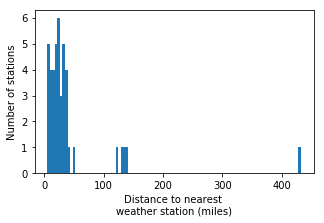

In [7]:
# appears that some wind farms don't really have reliable weather station data close by
# use this as exclusion criteria later (exclude those with dist>50 miles)
f,ax = plt.subplots(figsize=(5,3))
plt.hist(miledists,bins=100)
ax.set_xlabel('Distance to nearest \nweather station (miles)')
ax.set_ylabel('Number of stations')
plt.show();

In [8]:
# create dict of key:value pairs for wind farm : [weather_station, distance-to-weather-station] pairings
pairs = {}
for f, farm in enumerate(wind_farm_stns_df.loc[:,'station_name']):
    pairs[farm] = [wind_wthr_stns_df.loc[inds[f],'station_id'], miledists[f]]
    
# make pairs into a data frame for joining
tmp0 = pd.DataFrame(pd.DataFrame(pairs).iloc[0,:].astype(int))
tmp1 = pd.DataFrame(pd.DataFrame(pairs).iloc[1,:])
pairs = pd.concat((tmp0,tmp1),axis=1)
pairs.columns=['station_id','distance']
pairs.reset_index(inplace=True)
pairs.set_index('station_id', inplace=True)
display(pairs.head(5))

# joining with wind_speed_df with same index
wind_speed_df.set_index('station_id', inplace=True)
display(wind_speed_df.head(5))

,index,distance
station_id,,
716230,ADELAIDE,33.434798
716310,AMARANTH,12.352404
718200,AMHERST ISLAND,10.918720
712610,ARMOW,37.502623
715380,BELLE RIVER,16.875188


,hour,temp,dew_point,pressure,wind_dir,wind_speed,date,datetime,station_name,latitude,longitude,elevation
station_id,,,,,,,,,,,,
710630,0.0,15.08,12.92,100.45,60.0,9.1717,2017-01-01,2017-01-01 00:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
710630,1.0,15.26,13.28,100.41,60.0,8.0532,2017-01-01,2017-01-01 01:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
710630,2.0,14.90,12.92,100.36,50.0,6.9347,2017-01-01,2017-01-01 02:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
710630,3.0,14.90,13.10,100.30,50.0,5.8162,2017-01-01,2017-01-01 03:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
710630,4.0,16.34,14.54,100.32,50.0,4.6977,2017-01-01,2017-01-01 04:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0


In [9]:
# Join and do some final cleaning up of column names and data to exclude
final_wthr_df = wind_speed_df.join(pairs).reset_index()
final_wthr_df.dropna(inplace=True)
final_wthr_df.reset_index(inplace=True)
final_wthr_df.drop(columns='level_0', inplace=True)
final_wthr_df.rename(columns={'station_name':'weather_station_name'}, inplace=True)
final_wthr_df.rename(columns={'index':'station_name'}, inplace=True)
final_wthr_df = final_wthr_df.loc[final_wthr_df['distance']<=50,:]
display(final_wthr_df.head(10))

,station_id,hour,temp,dew_point,pressure,wind_dir,wind_speed,date,datetime,weather_station_name,latitude,longitude,elevation,station_name,distance
0,711610,0.0,33.26,31.82,100.35,200.0,10.2902,2017-01-01,2017-01-01 00:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
1,711610,1.0,33.08,32.18,100.32,200.0,11.4087,2017-01-01,2017-01-01 01:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
2,711610,2.0,32.54,32.00,100.31,190.0,8.0532,2017-01-01,2017-01-01 02:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
3,711610,3.0,32.90,32.36,100.27,200.0,9.1717,2017-01-01,2017-01-01 03:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
4,711610,4.0,32.54,32.00,100.32,200.0,11.4087,2017-01-01,2017-01-01 04:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
5,711610,5.0,31.10,32.00,100.31,200.0,10.2902,2017-01-01,2017-01-01 05:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
6,711610,6.0,32.90,32.54,100.37,200.0,9.1717,2017-01-01,2017-01-01 06:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
7,711610,7.0,33.44,32.54,100.45,200.0,8.0532,2017-01-01,2017-01-01 07:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
8,711610,8.0,34.16,29.66,100.62,240.0,17.2249,2017-01-01,2017-01-01 08:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
9,711610,9.0,33.62,28.76,100.79,240.0,16.1064,2017-01-01,2017-01-01 09:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582


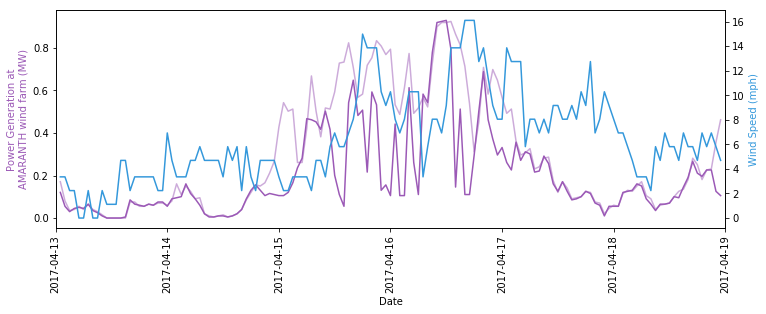

In [20]:
# Overlay windspeed and energy production vs time
# Inputs
# farm_stn = 'AMARANTH' # easy prediction
# farm_stn = 'GREENWICH' # some areas that might change due to wind direction/variability
stn = 'AMARANTH'

# wthr_stn = int(pairs[farm_stn][0]) # with station_id
# start_date  = dt.datetime(year, 4, 13)
# end_date = dt.datetime(year, 4, 19)
start_date  = dt.datetime(year, 4, 13)
end_date = dt.datetime(year, 4, 19)

# Create fig
f,ax = plt.subplots(figsize=(12,4))

# Create tmp dataframes
# actual & predicted wind power
tmp_wind_power_df = wind_power_df.loc[
    (wind_power_df['datetime']>start_date) & 
    (wind_power_df['datetime']<end_date) & 
    (wind_power_df['station_name']==stn)]
# wind speed
tmp_wind_speed_df = final_wthr_df.loc[
    (final_wthr_df['datetime']>start_date) & 
    (final_wthr_df['datetime']<end_date) & 
    (final_wthr_df['station_name']==stn)]

sns.lineplot(x='datetime', y='pmax_power_output', data=tmp_wind_power_df, color="#9b59b6")
sns.lineplot(x='datetime', y='pred_pmax_power_output', data=tmp_wind_power_df, color="#9b59b6", alpha=0.5)
plt.xticks(rotation=90)
ax2 = plt.twinx()
sns.lineplot(x='datetime', y='wind_speed', data=tmp_wind_speed_df, color="#3498db", ax=ax2)

ax.set_xlim([start_date,end_date])
ax.set_xlabel('Date')
ax.set_ylabel('Power Generation at\n' + stn + ' wind farm (MW)', color="#9b59b6")
ax2.set_ylabel('Wind Speed (mph)', color="#3498db")
plt.savefig(stn + '.png',dpi=500);

In [41]:
# figure out which stations have reliable data
# defined as those with mean power_output > 10 and more than 80% non-zero values for power_output

# Start just looking at AMARANTH predictions
reliable_stations = ['AMARANTH']

# Later we can look at all reliable station data
# reliable_stations = wind_power_df.groupby('station_name').agg({
#                 'station_name': lambda x: x.value_counts(),
#                 'power_output': lambda x: bool(x.mean()>10 and x.astype(bool).sum(axis=0)>7000)})
# reliable_stations = list(reliable_stations.loc[reliable_stations['power_output'],'station_name'].keys())
# display(reliable_stations)

In [42]:
# Import lstm packages
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [43]:
# Function to create lags in dataset
def create_lag(df, columnname, nlags=5):
    nolag = df[columnname].values
    nrows = len(nolag) - nlags - 1
    lagged = np.empty((0,))
    for n in range(nlags):
        start = 0 + n 
        end = nrows + n
        lagged = np.concatenate((lagged,nolag[start:end]), axis=0)
    return np.reshape(lagged,(nrows,nlags), order='F')

In [44]:
# set up predictors x station-by-station
def create_predictors(df, predictors_list, reliable_stations, nlags=5):
    x = np.empty((0,len(predictors_list)*nlags))
    for rs in reliable_stations:
        tmpdf = df.loc[df['station_name']==rs,:]
        x_ss = np.empty((len(tmpdf)-nlags-1, 0))
        for pr in predictors_list:
            x_ss_pr = create_lag(tmpdf, pr, nlags=nlags)
            x_ss = np.concatenate((x_ss, x_ss_pr), axis=1) # concatenate predictor variables by row
        x = np.concatenate((x,x_ss), axis=0) #stack station data by column
    return x

In [153]:
# Create lagged predictors
nlags = 12
features = ['hour','wind_speed','wind_dir','temp','dew_point','pressure','latitude','longitude','elevation']
X = create_predictors(final_wthr_df, features, reliable_stations, nlags=nlags)
Xtrain = X[168*0:168*1]
Xtrain = StandardScaler().fit_transform(Xtrain)
Xtrain = Xtrain.reshape((Xtrain.shape[0], nlags, len(features)))
Xtest = X[168*1:168*2]
Xtest = StandardScaler().fit_transform(Xtest)
Xtest = Xtest.reshape((Xtest.shape[0], nlags, len(features)))

y = wind_power_df.loc[wind_power_df['station_name']=='ARMOW','pmax_power_output'].values
y = y[nlags+1:]
y[y>=1] = 1
yTrain = y[168*0:168*1]
yTest = y[168*1:168*2]

C:\Users\alacroix367\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


In [154]:
# define LSTM model
model = Sequential()
model.add(LSTM(5, input_shape=(nlags,len(features)))) # 5 timesteps and 9 features
model.add(Dense(1))


# compile (precompute step)
# Perhaps the most commonly used optimization algorithms because of their generally better performance are:

# Stochastic Gradient Descent, or ‘sgd‘, that requires the tuning of a learning rate and momentum.
# ADAM, or ‘adam‘, that requires the tuning of learning rate.
# RMSprop, or ‘rmsprop‘, that requires the tuning of learning rate

# algorithm = SGD(lr=0.1, momentum=0.3)
model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(Xtrain, yTrain, batch_size=32, epochs=100, verbose=0)

In [155]:
# see what it predicted for first 200 data points
yPred = model.predict(Xtest)
yPred = np.reshape(yPred,(len(yPred),))
print(type(yPred))
print(yPred.shape)

<class 'numpy.ndarray'>
(168,)


In [156]:
time = np.linspace(0,len(yTest),len(yTest))
resultsdf = pd.DataFrame({
    'time': time,
    'actual': yTest,
    'predicted': yPred})

Text(0, 0.5, 'Predicted Percent Max Power Generation')

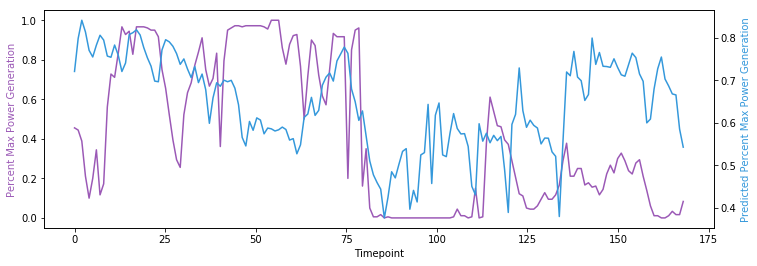

In [157]:
# Create fig
f,ax = plt.subplots(figsize=(12,4))

sns.lineplot(x='time', y='actual', data=resultsdf, color="#9b59b6")
ax2 = plt.twinx()
sns.lineplot(x='time', y='predicted', data=resultsdf, color="#3498db", ax=ax2)

ax.set_xlabel('Timepoint')
ax.set_ylabel('Percent Max Power Generation', color="#9b59b6")
ax2.set_ylabel('Predicted Percent Max Power Generation', color="#3498db")
# plt.savefig(stn + '.png',dpi=500);

# avoid over or under fitting model
# https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

In [97]:
from pandas.plotting import autocorrelation_plot, lag_plot

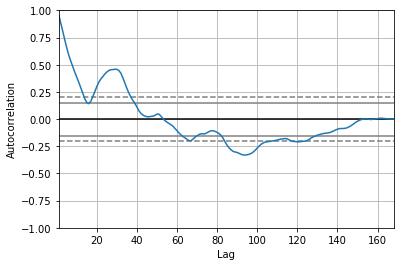

In [113]:
test = wind_power_df.loc[wind_power_df['station_name']=='AMARANTH','pred_pmax_power_output'].values
autocorrelation_plot(test[168*4:168*5])